## Imports

In [59]:
#Run the following once to install libraries needed for Matplotlib to work
#!conda install nomkl numpy scipy scikit-learn numexpr -y
#!conda remove mkl mkl-service -y

In [108]:
#Import pandas, matplotlib.pyplot, and seaborn in the correct lines below
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import requests

/Users/pandabear/anaconda/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [61]:
# Neighborhoods in SF
SFC_NEIGHBORHOODS = ['alamo square / nopa', 'bayview', 'bernal heights', 'castro / upper market', 'cole valley / ashbury hts', 'downtown / civic / van ness',
 'excelsior / outer mission', 'financial district', 'glen park', 'haight ashbury', 'hayes valley', 'ingleside / SFSU / CCSF', 'inner richmond',
 'inner sunset / UCSF', 'laurel hts / presidio', 'lower haight', 'lower nob hill', 'lower pac hts', 'marina / cow hollow', 'mission district',
 'nob hill', 'noe valley', 'north beach / telegraph hill', 'pacific heights', 'portola district', 'potrero hill', 'richmond / seacliff', 'russian hill', 
'SOMA / south beach', 'sunset / parkside', 'tenderloin','treasure island', 'twin peaks / diamond hts', 'USF / panhandle', 'visitacion valley', 
'west portal / forest hill', 'western addition']

# Neighborhoods in Peninsula
PEN_NEIGHBORHOODS = ['atherton','belmont','brisbane','burlingame','coastside/pescadero','daly city','east palo alto','foster city','half moon bay','los altos','menlo park','millbrae',
                     'mountain view','pacifica','palo alto','portola valley','redwood city','redwood shores','san bruno','san carlos','san mateo','south san francisco','woodside']

# Neighborhoods in the East Bay
EBY_NEIGHBORHOODS = ['alameda','albany / el cerrito','berkeley','berkeley north / hills','brentwood / oakley','concord / pleasant hill / martinez','danville / san ramon',
                     'dublin / pleasanton / livermore','emeryville','fairfield / vacaville','fremont / union city / newark','hayward / castro valley','hercules, pinole, san pablo, el sob',
                     'lafayette / orinda / moraga','oakland downtown','oakland east','oakland hills / mills','oakland lake merritt / grand','oakland north / temescal',
                     'oakland piedmont / montclair','oakland rockridge / claremont','oakland west','pittsburg / antioch','richmond / point / annex','san leandro','vallejo / benicia','walnut creek']
# List of cities
SFC_CITIES = ['San Francisco']
PEN_CITIES = ['Palo Alto','San Mateo','Mountain View','Redwood City','Menlo Park','Daly City','San Bruno','South San Francisco','Foster City','Burlingame']
EBY_CITIES = ['Oakland','Berkeley','Fremont','Walnut Creek','Concord','Hayward','Alameda','Pleasanton','San Leandro','Vallejo','San Ramon','Emeryville',
        'Dublin','Richmond','Fairfield','Livermore','Antioch','Pittsburg','Union City','El Cerrito']

ALL_CITIES = SFC_CITIES + PEN_CITIES + EBY_CITIES

# Dictionaries for neighborhood and city relationship
METRO_TO_NEIGHBORHOODS = {'sfc': SFC_NEIGHBORHOODS, 'pen': PEN_NEIGHBORHOODS, 'eby': EBY_NEIGHBORHOODS}
METRO_TO_CITIES = {'sfc': SFC_CITIES, 'pen': PEN_CITIES, 'eby': EBY_CITIES}

NEIGHBORHOOD_TO_METRO = {neighborhood: metro for metro, neighborhoods in METRO_TO_NEIGHBORHOODS.items() for neighborhood in neighborhoods}
CITY_TO_METRO = {city: metro for metro,cities in METRO_TO_CITIES.items() for city in cities}

# Create a dictionary mapping listing_info values to the categorical column name
LISTING_INFO_TO_COLUMN = {'cats are OK - purrr':'animals_cats','dogs are OK - wooof':'animals_dogs','furnished':'furnished',
                    'no smoking':'smoking','wheelchair accessible':'wheelchair accessible','air conditioning':'has_AC',
                     'EV charging':'hasEVCharging','laundry in bldg':'laundry_in_bldg','w/d in unit':'laundry_in_unit',
                     'w/d hookups':'laundry_has_hookup','laundry on site':'laundry_onsite','no laundry on site':'laundry_not_onsite',
                     'carport':'parking_carport','attached garage':'parking_attached_garage','detached garage':'parking_detached_garage',
                     'off-street parking':'parking_offstreet','street parking':'parking_street','valet parking':'parking_valet','no parking':'parking_none',
                     'rent period: daily':'rent_period_daily','rent period: weekly':'rent_period_weekly','rent period: monthly':'rent_period_monthly',
                     'condo':'housing_condo','apartment':'housing_apt','cottage/cabin':'housing_cottage','duplex':'housing_duplex',
                     'flat':'housing_flat','house':'housing_house','in-law':'housing_inlaw','loft':'housing_inlaw','townhouse':'housing_townhouse'}

# Create a dictionary mapping listing_body features to the categorical column name
LISTING_BODY_TO_COLUMN = {'rent control':'is_rent_controlled','no pets':'pets_allowed','remodelled':'is_remodelled',
                         '(amenities)|(pool)|(gym)':'has_amenities'}

In [62]:
def correct_metro(neighborhood, city):
    if city in CITY_TO_METRO:
        return NEIGHBORHOOD_TO_METRO[neighborhood] == CITY_TO_METRO[city]
    else:
        return False
    
def clean_city(city):
    city = city.strip()
    city = city.strip('.')
    if ',' in city:
        return city.split(',')[0]
    if '/' in city:
        return city.split('/')[0]
    return city

# Extract key features from listing_info
def get_listing_info_feature(listing_info_split, target_info):
    for info in listing_info_split:
        if info == target_info:
            return 1
    return 0

# Extract key features from listing_body
def parse_listing_body(text,target_word):
    for key in LISTING_BODY_TO_COLUMN.keys():
        if re.search(target_word, text.lower()) is not None:
            return 1
    return 0

## Load the data

In [63]:
# The parsed html listing data is the interim directory
dir_folder = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim/'
listing_df = pd.read_csv(dir_folder + 'listing_df.csv',index_col='listing_id')

# Select the first 10000 rows
# listing_df = listing_df.iloc[:10000,:]

In [64]:
listing_df.head()

,listing_address,listing_bathrooms,listing_bedrooms,listing_body,listing_city,listing_date,listing_first_image,listing_info,listing_nh,listing_price,listing_sqft,listing_title,listing_url
listing_id,,,,,,,,,,,,,
7506354686,24 Union Square,2,2,Furnished Available -Parking -Pool -Controlle...,Union City,2022-07-08T11:18:15-0700,https://images.craigslist.org/00P0P_hZ2AtgxDfz...,air conditioning cats are OK - purrr dogs a...,fremont / union city / newark,3250,1226.0,"At Last, This Is What You’ve Been Searching For",https://sfbay.craigslist.org/eby/apa/d/union-c...
7508776873,1625 15th Street,1,2,"Upgraded Single Family Home in San Pablo, CA...",San Pablo,2022-07-14T11:52:10-0700,https://images.craigslist.org/00101_70g2UwYKVU...,application fee details: $45 Online Applicati...,"hercules, pinole, san pablo, el sob",2600,NaN,"Upgraded Single Family Home in San Pablo, CA",https://sfbay.craigslist.org/eby/apa/d/richmon...
7520158858,3900 Business Center Dr near Business Center D...,1,1,Verdant at Green Valley 3900 Business Center D...,Fairfield,2022-08-11T11:38:28-0700,https://images.craigslist.org/00707_7hc2WHQqbx...,cats are OK - purrr dogs are OK - wooof apa...,fairfield / vacaville,2102,712.0,"Business Center, Parcel Lockers, Disposal, Com...",https://sfbay.craigslist.org/eby/apa/d/fairfie...
7509730537,36000 Fremont Blvd,1,1,To schedule a tour We now book our tour appoin...,Fremont,2022-07-16T16:43:33-0700,https://images.craigslist.org/00N0N_5CCDB2ckEM...,cats are OK - purrr dogs are OK - wooof apa...,fremont / union city / newark,2325,610.0,Unwind at Casa Serena!,https://sfbay.craigslist.org/eby/apa/d/fremont...
7516143553,NaN,2,3,3 Beds 2 Baths single family house Excellent ...,San Leandro,2022-08-01T14:25:13-0700,https://images.craigslist.org/00z0z_cJsvz9nR7M...,air conditioning cats are OK - purrr dogs a...,san leandro,3500,1300.0,House for rent - 5 mins walk to Bart 3bed room...,https://sfbay.craigslist.org/eby/apa/d/san-lea...


In [65]:
listing_df.describe()

,listing_bedrooms,listing_price,listing_sqft
count,57063.000000,5.706300e+04,47281.000000
mean,1.556403,5.304582e+03,899.204839
std,0.911339,2.810062e+05,1020.222018
min,0.000000,1.000000e+00,1.000000
25%,1.000000,2.380000e+03,658.000000
50%,2.000000,2.900000e+03,804.000000
75%,2.000000,3.711000e+03,1019.000000
max,8.000000,3.875318e+07,94103.000000


In [66]:
listing_dr_rows = listing_df.shape[0]
listing_df.shape

(57063, 13)

In [67]:
# Drop rows that are missing price data
#listing_df = listing_df.dropna(subset=['listing_price'])

# Drop rows where price is below a chosen min and max
price_min = 500
price_max = 20000
listing_df = listing_df.loc[(listing_df.listing_price > price_min) & (listing_df.listing_price < price_max)]

In [68]:
listing_df.describe()

,listing_bedrooms,listing_price,listing_sqft
count,56980.000000,56980.000000,47247.000000
mean,1.554879,3231.630344,897.798273
std,0.907461,1370.540204,1016.665570
min,0.000000,505.000000,1.000000
25%,1.000000,2380.000000,658.000000
50%,2.000000,2900.000000,804.000000
75%,2.000000,3710.000000,1016.500000
max,8.000000,18995.000000,94103.000000


## Removing duplicate listings

In [69]:
# Look at the number of exact duplicates
duplicates = listing_df['listing_title'].value_counts()
duplicates.head()

First-floor two-bedroom in Theater District        293
***UP to 8-weeks OFF RENT!!*** Apply Today!        199
Amazing 2 bed 2 bath home                          151
MINUTES FROM DOWNTOWN BURLINGAME!                  149
$2,395 / 1br - BEAUTIFUL 1 BED 1 BATH APARTMENT    121
Name: listing_title, dtype: int64

In [70]:
print('Total number of duplicates by listing title: {}'.format(duplicates[duplicates != 1].sum()))

Total number of duplicates by listing title: 53668


In [71]:
# Drop duplicates using 3 filters: (Note: optional fields in craigslist are address, neighborhood)
# 1. Drop duplicates by subset of title, bedroom, bathroom, neighborhood
df_drop_by_filter1 = listing_df.drop_duplicates(subset = ['listing_title','listing_bedrooms','listing_bathrooms','listing_nh'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 1: {df_drop_by_filter1.shape[0]} rows, {df_drop_by_filter1.shape[1]} columns")
print(f"Filter 1 dropped {listing_dr_rows - df_drop_by_filter1.shape[0]} rows")

Dataframe size after filter 1: 21956 rows, 13 columns
Filter 1 dropped 35107 rows


In [72]:
# 2. Drop duplicates by subset of image link, bedroom, bathroom, neighborhood
df_drop_by_filter2 = df_drop_by_filter1.drop_duplicates(subset = ['listing_first_image','listing_bedrooms','listing_bathrooms','listing_nh'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 2: {df_drop_by_filter2.shape[0]} rows, {df_drop_by_filter2.shape[1]} columns")
print(f"Filter 2 dropped {df_drop_by_filter1.shape[0] - df_drop_by_filter2.shape[0]} rows")

Dataframe size after filter 2: 16627 rows, 13 columns
Filter 2 dropped 5329 rows


In [73]:
# 3. Drop duplicates by subset of listing_address, listing_city, bedroom, bathroom
df_drop_by_filter3 = df_drop_by_filter2.drop_duplicates(subset = ['listing_address','listing_city','listing_bedrooms','listing_bathrooms'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 3: {df_drop_by_filter3.shape[0]} rows, {df_drop_by_filter3.shape[1]} columns")
print(f"Filter 3 dropped {df_drop_by_filter2.shape[0] - df_drop_by_filter3.shape[0]} rows")

Dataframe size after filter 3: 8001 rows, 13 columns
Filter 3 dropped 8626 rows


In [74]:
# Compare with dropping duplicates based on all columns
df_drop_by_all_cols = listing_df.drop_duplicates(keep = 'last', inplace = False)
df_drop_by_all_cols.shape
print(f"Dataframe size after dropping based on all columns: {df_drop_by_all_cols.shape[0]} rows, {df_drop_by_all_cols.shape[1]} columns")
print(f"Dropping duplicates by all columns dropped {listing_dr_rows - df_drop_by_all_cols.shape[0]} rows")

Dataframe size after dropping based on all columns: 29852 rows, 13 columns
Dropping duplicates by all columns dropped 27211 rows


In [75]:
# Use all 3 filters
df = df_drop_by_filter3
df.head()

,listing_address,listing_bathrooms,listing_bedrooms,listing_body,listing_city,listing_date,listing_first_image,listing_info,listing_nh,listing_price,listing_sqft,listing_title,listing_url
listing_id,,,,,,,,,,,,,
7520238715,larchmont st near santa clara,1,0,In Law Studio with private entrance. There is ...,Hayward,2022-08-11T14:27:20-0700,https://images.craigslist.org/00O0O_bJHOplrM7G...,in-law laundry on site no smoking street p...,hayward / castro valley,1495,NaN,"Cozy bright tudio, private entrance, convenien...",https://sfbay.craigslist.org/eby/apa/d/hayward...
7520722195,562 29th Street,1,2,"Capture The Charm, Love The Space, Live The ...",Oakland,2022-08-12T17:17:07-0700,https://images.craigslist.org/00f0f_6WN3vHUujM...,cats are OK - purrr dogs are OK - wooof con...,oakland east,2660,668.0,Ultimate 2BR/1BA Condo - 562 29th Street,https://sfbay.craigslist.org/eby/apa/d/oakland...
7520103440,Newport Dr,2,3,Great location 3 Bed 2 Bath Single Family Hous...,Fremont,2022-08-11T09:51:58-0700,https://images.craigslist.org/00C0C_iEcKsVmzdg...,open house dates saturday 2022-08-13 sun...,fremont / union city / newark,3800,1495.0,Beautiful and Spacious NEW remodeled Silicon V...,https://sfbay.craigslist.org/eby/apa/d/fremont...
7514395720,3051 Adeline #E near Essex,1,1,OFFICE USE ONLY Italian tile floors Priced f...,Berkeley,2022-07-28T08:02:39-0700,https://images.craigslist.org/00S0S_esApZyWjnu...,open house dates saturday 2022-08-13 sun...,berkeley,1595,400.0,OFFICE STUDIO,https://sfbay.craigslist.org/eby/apa/d/berkele...
7520675660,Gateway Drive near Griffin Drive,1,1,Great ADU Newly Remodeled! New Everything! V...,Vallejo,2022-08-12T15:07:04-0700,https://images.craigslist.org/00G0G_h0W8q8v9Py...,apartment no laundry on site no smoking of...,vallejo / benicia,1650,560.0,Great ADU Newly Remodeled! New Everything! Val...,https://sfbay.craigslist.org/eby/apa/d/vallejo...


In [76]:
df.dtypes

listing_address         object
listing_bathrooms       object
listing_bedrooms         int64
listing_body            object
listing_city            object
listing_date            object
listing_first_image     object
listing_info            object
listing_nh              object
listing_price            int64
listing_sqft           float64
listing_title           object
listing_url             object
dtype: object

In [77]:
df.is_copy = False
# Convert the columns into the correct dtype
df['listing_date'] = pd.to_datetime(df['listing_date'])

In [78]:
# Trim trailing spaces on string values in listing_bathrooms
df['listing_bathrooms'] = df['listing_bathrooms'].map(lambda x: x.strip())
df['listing_bathrooms'].unique()

array(['1', '2', '2.5', '1.5', '3.5', '3', 'split', 'shared', '4', '4.5',
       '5.5', '5', '6', '6.5', '9+', '8'], dtype=object)

In [79]:
df['listing_bathrooms'].value_counts()

1         4952
2         1845
1.5        361
2.5        325
3          269
3.5         69
shared      66
split       54
4           38
4.5         12
5            5
6.5          1
5.5          1
9+           1
8            1
6            1
Name: listing_bathrooms, dtype: int64

In [80]:
# 1 split bathroom is the same as 1 bathroom, so convert 'split' to type '1'
df['listing_bathrooms'][df['listing_bathrooms'] == 'split'] = '1'

# Since these are the only inputs for bathroom in the craigslist UI, lump all bathrooms > 3 into a single type '3+'
extra_bath = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5','9+']
df['listing_bathrooms'][df['listing_bathrooms'].isin(extra_bath)] = '4+'

/Users/pandabear/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/pandabear/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [81]:
df['listing_bathrooms'].value_counts()

1         5006
2         1845
1.5        361
2.5        325
3          269
3.5         69
shared      66
4+          60
Name: listing_bathrooms, dtype: int64

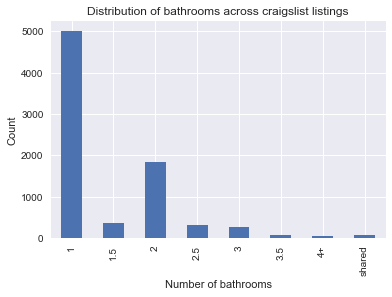

In [82]:
df['listing_bathrooms'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')
plt.title('Distribution of bathrooms across craigslist listings')

In [83]:
# Lump all bedrooms >= 6 into a single type '6+'
extra_bed = ['6', '7', '8']
df['listing_bedrooms'] = df['listing_bedrooms'].astype('str')
df['listing_bedrooms'][df['listing_bedrooms'].isin(extra_bed)] = '6+'
df['listing_bedrooms'].value_counts()

/Users/pandabear/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2     2704
1     2657
3     1236
0      778
4      491
5      100
6+      35
Name: listing_bedrooms, dtype: int64

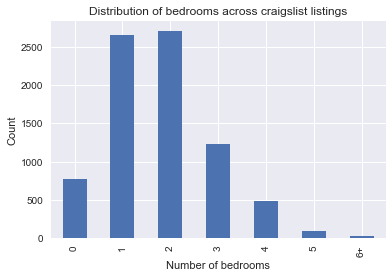

In [84]:
# Look at distributions of number of bedroom data
df['listing_bedrooms'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of bedrooms')
plt.ylabel('Count')
plt.title('Distribution of bedrooms across craigslist listings')

In [85]:
df['listing_sqft'].describe()
# Drop sqft values that are too small or too big (the 94103 is clearly a zip code)
sqft_min = 200
sqft_max = 30000
df = df.loc[(df.listing_sqft > sqft_min) & (df.listing_sqft < sqft_max)]

In [86]:
# df['listing_sqft'].describe()

In [87]:
# Convert listing_info from string of values to a list of values
df['listing_info_split'] = df['listing_info'].apply(lambda x: x.strip().split("  "))

/Users/pandabear/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [88]:
for target_info, column in LISTING_INFO_TO_COLUMN.items():
    df[column] = df['listing_info_split'].apply(lambda x: get_listing_info_feature(x, target_info))

/Users/pandabear/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [89]:
df.head()

,listing_address,listing_bathrooms,listing_bedrooms,listing_body,listing_city,listing_date,listing_first_image,listing_info,listing_nh,listing_price,...,rent_period_weekly,rent_period_monthly,housing_condo,housing_apt,housing_cottage,housing_duplex,housing_flat,housing_house,housing_inlaw,housing_townhouse
listing_id,,,,,,,,,,,,,,,,,,,,,
7520722195,562 29th Street,1,2,"Capture The Charm, Love The Space, Live The ...",Oakland,2022-08-13 00:17:07,https://images.craigslist.org/00f0f_6WN3vHUujM...,cats are OK - purrr dogs are OK - wooof con...,oakland east,2660,...,0,1,1,0,0,0,0,0,0,0
7520103440,Newport Dr,2,3,Great location 3 Bed 2 Bath Single Family Hous...,Fremont,2022-08-11 16:51:58,https://images.craigslist.org/00C0C_iEcKsVmzdg...,open house dates saturday 2022-08-13 sun...,fremont / union city / newark,3800,...,0,0,0,0,0,0,0,0,0,0
7514395720,3051 Adeline #E near Essex,1,1,OFFICE USE ONLY Italian tile floors Priced f...,Berkeley,2022-07-28 15:02:39,https://images.craigslist.org/00S0S_esApZyWjnu...,open house dates saturday 2022-08-13 sun...,berkeley,1595,...,0,0,0,0,0,0,0,0,0,0
7520675660,Gateway Drive near Griffin Drive,1,1,Great ADU Newly Remodeled! New Everything! V...,Vallejo,2022-08-12 22:07:04,https://images.craigslist.org/00G0G_h0W8q8v9Py...,apartment no laundry on site no smoking of...,vallejo / benicia,1650,...,0,1,0,1,0,0,0,0,0,0
7520606430,Kensington near Elm,1,1,"Newly remodeled , with a big Kitchen , Bathroo...",East Richmond Heights ( hills neighborho,2022-08-12 19:31:17,https://images.craigslist.org/00n0n_9HaJCX8cT7...,cats are OK - purrr cottage/cabin laundry o...,richmond / point / annex,1795,...,0,1,0,0,1,0,0,0,0,0


In [90]:
df['listing_city'] = df['listing_city'].apply(lambda x: x.title())
df['listing_city'] = df['listing_city'].apply(lambda x: clean_city(x))
df['listing_city'].value_counts()

# Get index of cities that occur less than 5 times (these are typos or errors)
x = df['listing_city'].value_counts()
city_to_drop = list((x[x < 5]).index)

# Drop city values that are lower than a value count of 2
df['listing_city'] = df['listing_city'].apply(lambda x: None if x in city_to_drop else x)

/Users/pandabear/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/pandabear/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/pandabear/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [107]:
df['listing_city'].value_counts().head()

San Francisco    1472
Oakland           751
Berkeley          260
Fremont           153
Palo Alto         141
Name: listing_city, dtype: int64

In [98]:
# If a listing has a neighborhood tag, cross reference it with the listing_city to make sure it is in the correct city, otherwise remove from df
df['is_consistent_metro'] = df.apply(lambda x: correct_metro(x['listing_nh'], x['listing_city']), axis=1)
df = df[df['is_consistent_metro'] == True]
df.is_copy = False

In [93]:
# Missing values in numeric columns
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_address,178,3.768791
laundry_has_hookup,0,0.000000
laundry_not_onsite,0,0.000000
parking_carport,0,0.000000
parking_attached_garage,0,0.000000
parking_detached_garage,0,0.000000
parking_offstreet,0,0.000000
parking_street,0,0.000000
parking_valet,0,0.000000
parking_none,0,0.000000


In [94]:
for target_word, column_name in LISTING_BODY_TO_COLUMN.items():
    df[column_name] = df['listing_body'].apply(lambda x: parse_listing_body(x, target_word))

In [95]:
df.head()

,listing_address,listing_bathrooms,listing_bedrooms,listing_body,listing_city,listing_date,listing_first_image,listing_info,listing_nh,listing_price,...,housing_duplex,housing_flat,housing_house,housing_inlaw,housing_townhouse,is_consistent_metro,is_rent_controlled,pets_allowed,is_remodelled,has_amenities
listing_id,,,,,,,,,,,,,,,,,,,,,
7520722195,562 29th Street,1,2,"Capture The Charm, Love The Space, Live The ...",Oakland,2022-08-13 00:17:07,https://images.craigslist.org/00f0f_6WN3vHUujM...,cats are OK - purrr dogs are OK - wooof con...,oakland east,2660,...,0,0,0,0,0,True,0,0,0,1
7520103440,Newport Dr,2,3,Great location 3 Bed 2 Bath Single Family Hous...,Fremont,2022-08-11 16:51:58,https://images.craigslist.org/00C0C_iEcKsVmzdg...,open house dates saturday 2022-08-13 sun...,fremont / union city / newark,3800,...,0,0,0,0,0,True,0,0,0,0
7514395720,3051 Adeline #E near Essex,1,1,OFFICE USE ONLY Italian tile floors Priced f...,Berkeley,2022-07-28 15:02:39,https://images.craigslist.org/00S0S_esApZyWjnu...,open house dates saturday 2022-08-13 sun...,berkeley,1595,...,0,0,0,0,0,True,0,0,0,0
7520675660,Gateway Drive near Griffin Drive,1,1,Great ADU Newly Remodeled! New Everything! V...,Vallejo,2022-08-12 22:07:04,https://images.craigslist.org/00G0G_h0W8q8v9Py...,apartment no laundry on site no smoking of...,vallejo / benicia,1650,...,0,0,0,0,0,True,0,1,0,1
7520515344,2033 Blake St,1,2,We give you luxury living and luxury location ...,Berkeley,2022-08-12 16:37:52,https://images.craigslist.org/00t0t_eGB7bOXCaZ...,EV charging air conditioning cats are OK - ...,berkeley,4196,...,0,0,0,0,0,True,0,0,0,1


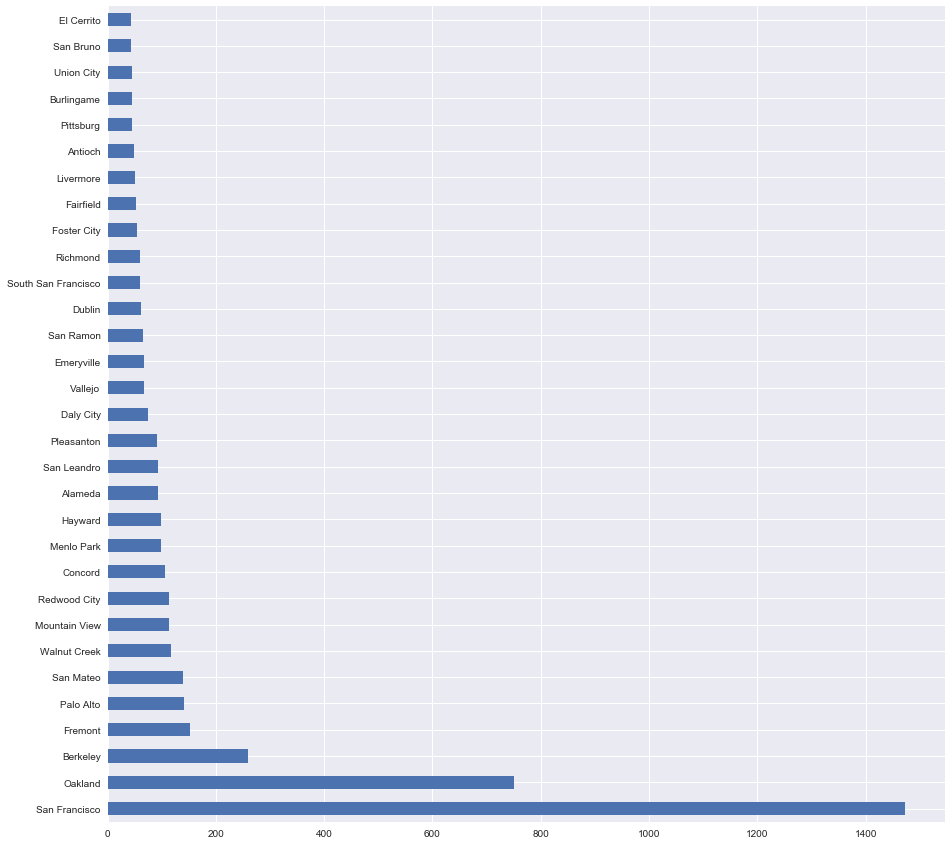

In [96]:
df['listing_city'].value_counts().head(50).plot(kind='barh',figsize=(15,15))

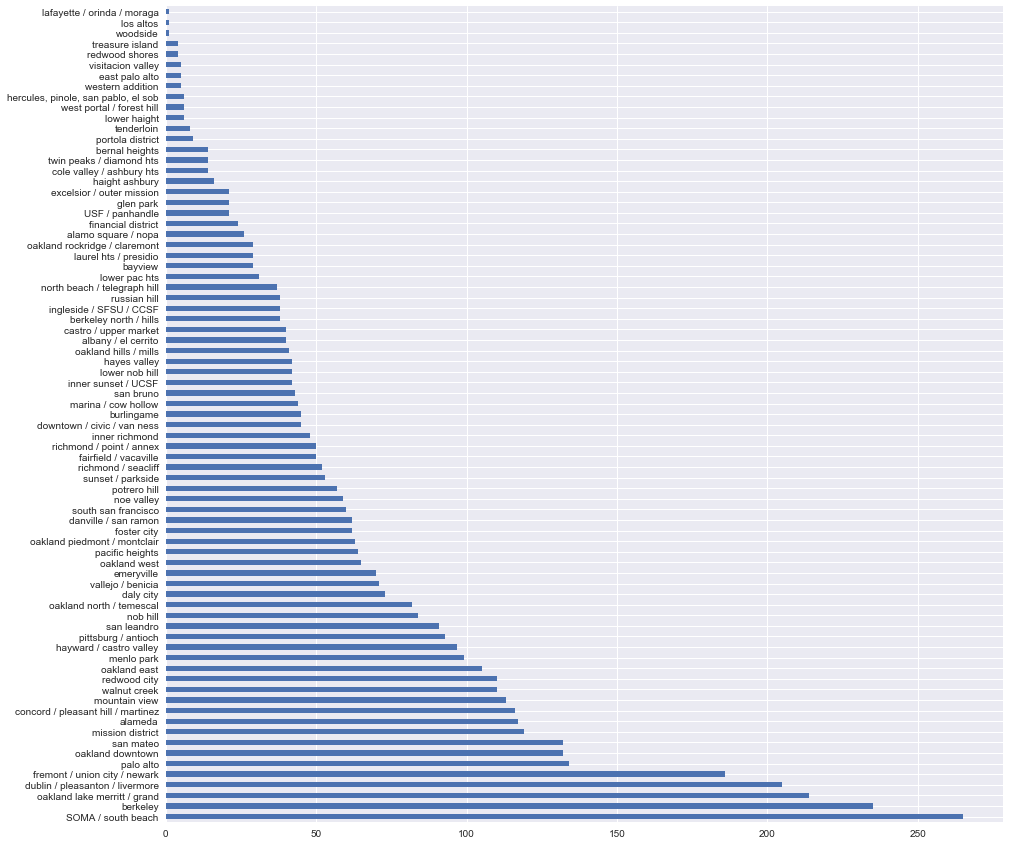

In [97]:
df['listing_nh'].value_counts().plot(kind='barh',figsize=(15,15))

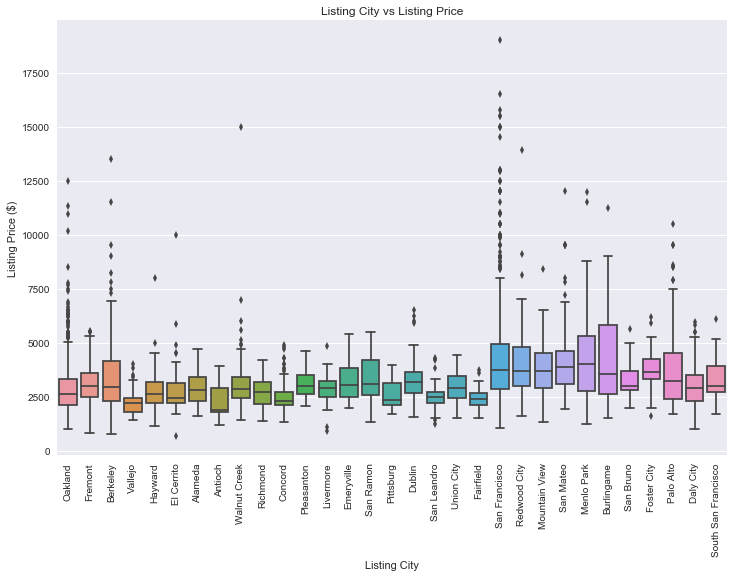

In [106]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='listing_city', y='listing_price', data=df)
plt.xticks(rotation='vertical')
plt.ylabel('Listing Price ($)')
plt.xlabel('Listing City')
plt.title('Listing City vs Listing Price');

In [109]:
listing_df.to_csv(r'/Users/pandabear/springboard/CapstoneTwoProject/data/interim/listing_df_cleaned.csv', header=True)
print('Saved to csv file')

Saved to csv file
